In [1]:
!pip install pytorch-lightning torchmetrics

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict
import pickle
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import LearningRateMonitor
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls ./drive/MyDrive/datasets/RML2016.1a

RML2016.10a_dict.pkl


In [5]:
path = './drive/MyDrive/datasets/RML2016.1a/RML2016.10a_dict.pkl'

In [6]:
def read(path: str) -> Tuple[np.ndarray, Dict]:
    with open(path, "rb") as infile:
        data = pickle.load(infile, encoding="latin")

        description = defaultdict(list)
        # Declare j just to get the linter to stop complaining about the lamba below
        j = None
        snrs, mods = map(
            lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1, 0]
        )
        for mod in mods:
            for snr in snrs:
                description[mod].append(snr)

        return data, description

In [7]:
data, description = read(path)

In [8]:
# list the available modulation types
description.keys()

dict_keys(['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'])

In [9]:
# categorize the modulation types into digital and anolog
analog_modulations = ["WBFM", "AM-SSB", "AM-DSB"]
digital_modulations = ["BPSK", "QPSK", "8PSK", "QAM16", "CPFSK", "GFSK", "PAM4", "QAM64"]

In [10]:
df = pd.DataFrame(columns=["SNR", "I", "Q", "Modulation"])

for modulation in description.keys():
    if modulation in digital_modulations:
        for snr in description[modulation]:
            mod_snr = data[(modulation, snr)]
            df_section = pd.DataFrame(columns=["SNR", "I", "Q", "Modulation"])
            df_section['SNR'] = np.ones(mod_snr.shape[0]) * snr
            df_section['Modulation'] = mod_snr.shape[0] * [modulation]

            for idx, v in enumerate(mod_snr):
                df_section['I'][idx] = v[0,...]
                df_section['Q'][idx] = v[1,...]
                idx += 1

            df = df.append(df_section, ignore_index=True)
    else:
        print(f"Discarding: {modulation}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Discarding: AM-DSB
Discarding: AM-SSB
Discarding: WBFM


In [11]:
# convert the Modulation column into a Target categorical colum
le = preprocessing.LabelEncoder()
df['Target'] = le.fit_transform(df['Modulation'])

In [12]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (160000, 5)


In [13]:
# Split the data into train, val, and test. Make sure the split is stratified across signal-to-noise-ratio (SNR)
X_train, X_test = train_test_split(df, stratify=df["SNR"].values, test_size=0.15)

## uncomment the line bellow if you are tuning the model
# X_train, X_val = train_test_split(X_train, stratify=X_train["SNR"].values, test_size=0.05)

In [14]:
print(f"Train data shape: {X_train.shape}")

## uncomment the line bellow if you are tuning the model
# print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (136000, 5)
Test data shape: (24000, 5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69325c5c90>]],
      dtype=object)

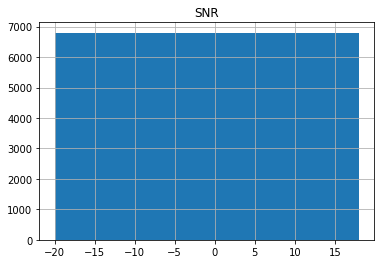

In [15]:
# make sure that train and test have equal observations accross SNR
X_train.hist('SNR', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69309245d0>]],
      dtype=object)

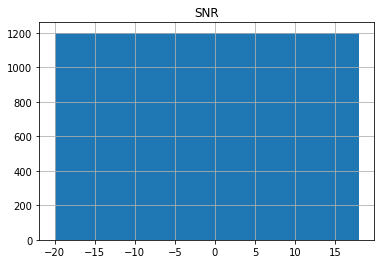

In [16]:
# make sure that train and test have equal observations accross SNR
X_test.hist('SNR', bins=20)

In [17]:
def create_pytorch_dataset(df, target_column : str = "Target"):
    data = np.stack([np.stack(df['I'].values, axis=0), np.stack(df['Q'].values, axis=0)], axis=1)
    data = np.expand_dims(data, axis=1)
    dataset = torch.utils.data.TensorDataset(torch.tensor(data),torch.tensor(df[target_column].values))
    return dataset

In [18]:
train_dataset, train_max_values = create_pytorch_dataset(X_train, normalize=True)

## uncomment the line bellow if you are tuning the model
# val_dataset = create_pytorch_dataset(X_val)
test_dataset = create_pytorch_dataset(X_test)

In [19]:
for x, y in train_dataset:
    print(x.shape, y)
    print(x.min(), x.max())
    break

for x, y in test_dataset:
    print(x.shape, y)
    print(x.min(), x.max())
    break

torch.Size([1, 2, 128]) tensor(1)
tensor(-0.4688) tensor(0.4818)
torch.Size([1, 2, 128]) tensor(2)
tensor(-0.3661) tensor(0.5890)


In [20]:
class Classifier(pl.LightningModule):
    def __init__(self, input_samples: int, n_classes: int):
        
        super().__init__()
        self.learning_rate = 0.2754228703338169 # set with pytorch tune()
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(1, 7),
                padding=(0, 3),
                bias=False,
            ),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(64),

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(1, 7),
                padding=(0, 3),
                bias=True,
            ),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(2, 7),
                padding=(0, 3),
                bias=True,
            ),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            
            nn.Linear(256 * 1 * input_samples, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

    def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), weight_decay=0.0002, lr=self.learning_rate)
        optimizer = torch.optim.SGD(self.parameters(), 
                                    momentum=0.9, lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.network(x)    

        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.train_accuracy(logits, y))
        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_accuracy.compute())

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.network(x)    
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc_step', self.val_accuracy(logits, y))

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            train_dataset, shuffle=True, batch_size=512
        )
        return train_loader
    
    # uncomment this method if you are tuning the model with the validation set
    # def val_dataloader(self):
    #     val_loader = torch.utils.data.DataLoader(
    #         val_dataset, shuffle=True, batch_size=1024
    #     )
    #     return val_loader

In [21]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=1024
)

In [22]:
epochs = 30

In [23]:
# model
model = Classifier(input_samples=128, n_classes=len(le.classes_))

lr_monitor = LearningRateMonitor(logging_interval='step')

# training
trainer = pl.Trainer(min_epochs=0, max_epochs=epochs, check_val_every_n_epoch=1,
                     val_check_interval=0.25, auto_lr_find=True, callbacks=[lr_monitor], gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
# find the best learning rate
## uncomment the line bellow if you are tuning the model
# trainer.tune(model)

In [25]:
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | train_accuracy | Accuracy   | 0     
1 | val_accuracy   | Accuracy   | 0     
2 | network        | Sequential | 8.9 M 
----------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.637    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

In [26]:
preds = []
targets = []
model.eval()

for x, y in test_loader:
    logits = model(x)
    preds.extend(torch.argmax(logits, dim=1))
    targets.extend(y)
    
preds = torch.tensor(preds)
targets = torch.tensor(targets)

In [27]:
confmat = ConfusionMatrix(num_classes=8)
cm = confmat(preds, targets)

In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True) ->float:
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return accuracy

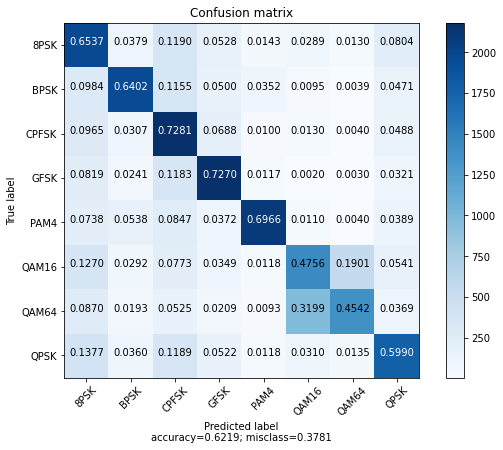

0.6219166666666667

In [29]:
plot_confusion_matrix(cm.numpy(), target_names=le.classes_)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_list = []
for group_id, group_df in X_test.groupby("SNR"):
    dataset = create_pytorch_dataset(group_df)
    X = dataset.tensors[0]
    y = dataset.tensors[1]
    predictions = model(X)
    cm = confmat(predictions, y)
    acc = plot_confusion_matrix(cm.numpy(), target_names=le.classes_, title=f"Confusion Matrix for SNR={group_id}")
    accuracy_list.append(acc)

AttributeError: ignored

In [ ]:
results_df = pd.DataFrame({"SNR": np.unique(X_test['SNR'].values), "Accuracy": accuracy_list})

In [ ]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(results_df, x="SNR", y="Accuracy", title='Classifier Performance vs SNR')
fig.show()